<a href="https://colab.research.google.com/github/davidtweedle/low-rank-approximation-demo/blob/main/Low-rank-approximation-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment results
---------------------
In this short notebook, I will demonstrate the power of the SVD for approximating the gradient. We approximate the gradients of the parameters by low rank matrices using either a randomized svd method (see ['Finding structure with randomness: Probabilistic algorithms for constructing matrix decompositions](https://arxiv.org/abs/0909.4061)) or a sketching method (see [Fast and stable randomized low-rank matrix approximation](https://arxiv.org/pdf/2009.11392). Surprisingly, we are able to approximate the gradient on every step using this method. This turns out to be faster than one would expect.

## Introduction
In this notebook, I will briefly introduce an algorithm for optimizing machine learning models across multiple GPUs. Then I will compare preliminary performance on the criteo and fastmri datasets from the AlgoPerf competition hosted by the ML Commons ([AlgoPerf competition](https://github.com/mlcommons/algorithmic-efficiency)).

First, recall the gradient descent algorithm
```
1. input <- x
2. output <- model(x)
3. loss <- loss_fn(output)
3. grad <- model.params.gradient
4. model.params <- model.params - learning_rate * grad
5. GOTO 1 # (perhaps choosing a different sample x, stopping when the accuracy is suitably nice)
```
and assuming that each model parameter comes in the form of an m by n matrix (or other suitable tensor) we make the following modification

```
3.' grad <- LOW_RANK_APPROXIMATION(model.params.gradient)
```
Usually, our LOW_RANK_APPROXIMATION function is taken to either be a randomized svd (for example, see [torch.svd_lowrank](https://pytorch.org/docs/stable/generated/torch.svd_lowrank.html)) or a sketching method.
For example, if $\mathrm{grad} = U \cdot \Sigma \cdot V^*$ then we take $\mathrm{grad} \sim U[:rank] \cdot \Sigma[:rank] \cdot V[:rank]^*$ where rank is hopefully small relative to the size of grad.

Please also note the similarity to [GaLORE](https://arxiv.org/abs/2403.03507), but in principle these are two separate algorithms with separate goals.

## Motivation
This algorithm was originally developed as a submission to the AlgoPerf machine learning competition.
Please understand that development is ongoing especially as my resources are quite limited.
Thanks are due to the MLCommons Algorithms Working Group who have generously provided time on the submission hardware to further develop my submission.

## The data
The data I have collected was generated from running my algorithm on the fastmri and criteo dataset using the [AlgoPerf](https://github.com/mlcommons/algorithmic-efficiency) library.
For comparison, I have used the prize qualification baseline from the AlgoPerf competition.

### Import modules and load data

In [1]:
import os
using_colab = 'COLAB_GPU' in os.environ
prefix = ""
if using_colab:
    ! git clone https://github.com/davidtweedle/low-rank-approximation-demo.git
    prefix = "low-rank-approximation-demo/"

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
prize_qual_fastmri = pd.read_csv(prefix + "data/prize_qual_fastmri/eval_measurements.csv")
prize_qual_criteo = pd.read_csv(prefix + "data/prize_qual_criteo/eval_measurements.csv")
low_rank_criteo = pd.read_csv(prefix + "data/low_rank_criteo/eval_measurements_criteo_low_rank.csv")
low_rank_fastmri = pd.read_csv(prefix + "data/low_rank_fastmri/eval_measurements_fastmri_low_rank.csv")

### Comparisons

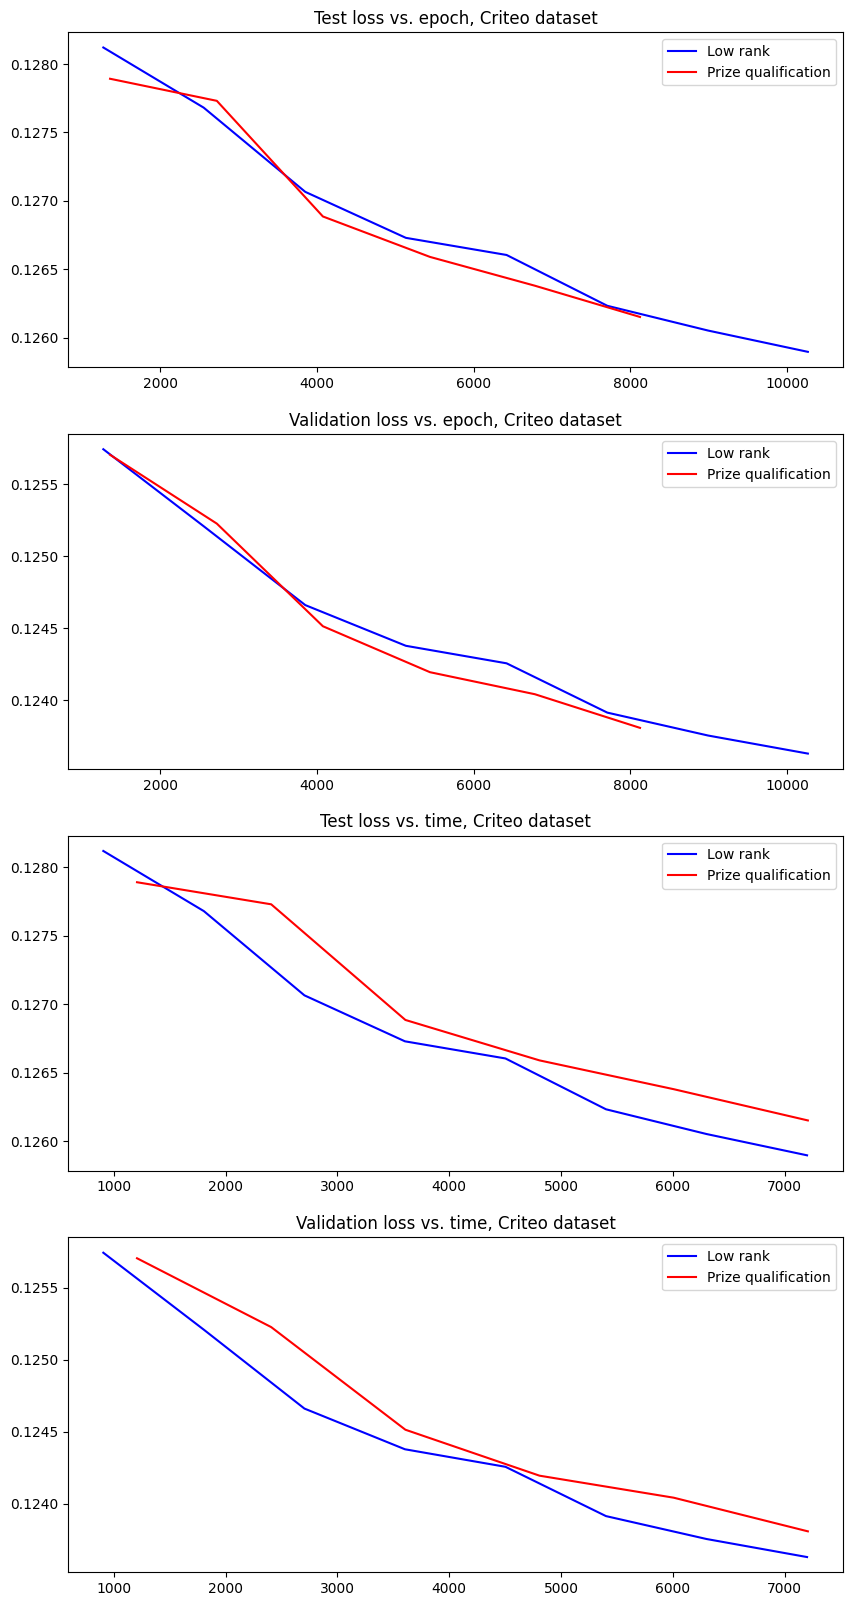

In [16]:
## Compare criteo prize qualification vs. low rank performance
## Note that parameters and rng seed were chosen to match
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
ax1.set_title("Test loss vs. epoch, Criteo dataset")
ax1.plot(low_rank_criteo['global_step'][1:], low_rank_criteo['test/loss'][1:],'b-', label='Low rank')
ax1.plot(prize_qual_criteo['global_step'][1:], prize_qual_criteo['test/loss'][1:], 'r-', label='Prize qualification')
ax1.legend()
ax2.set_title("Validation loss vs. epoch, Criteo dataset")
ax2.plot(low_rank_criteo['global_step'][1:], low_rank_criteo['validation/loss'][1:],'b-', label='Low rank')
ax2.plot(prize_qual_criteo['global_step'][1:], prize_qual_criteo['validation/loss'][1:], 'r-', label='Prize qualification')
ax2.legend()
ax3.set_title("Test loss vs. time, Criteo dataset")
ax3.plot(low_rank_criteo['accumulated_submission_time'][1:], low_rank_criteo['test/loss'][1:],'b-', label='Low rank')
ax3.plot(prize_qual_criteo['accumulated_submission_time'][1:], prize_qual_criteo['test/loss'][1:], 'r-', label='Prize qualification')
ax3.legend()
ax4.set_title("Validation loss vs. time, Criteo dataset")
ax4.plot(low_rank_criteo['accumulated_submission_time'][1:], low_rank_criteo['validation/loss'][1:],'b-', label='Low rank')
ax4.plot(prize_qual_criteo['accumulated_submission_time'][1:], prize_qual_criteo['validation/loss'][1:], 'r-', label='Prize qualification')
ax4.legend()

## Note that the low rank approximation on 2 gpu's was only run for 15000 steps instead of the full 37400 steps.

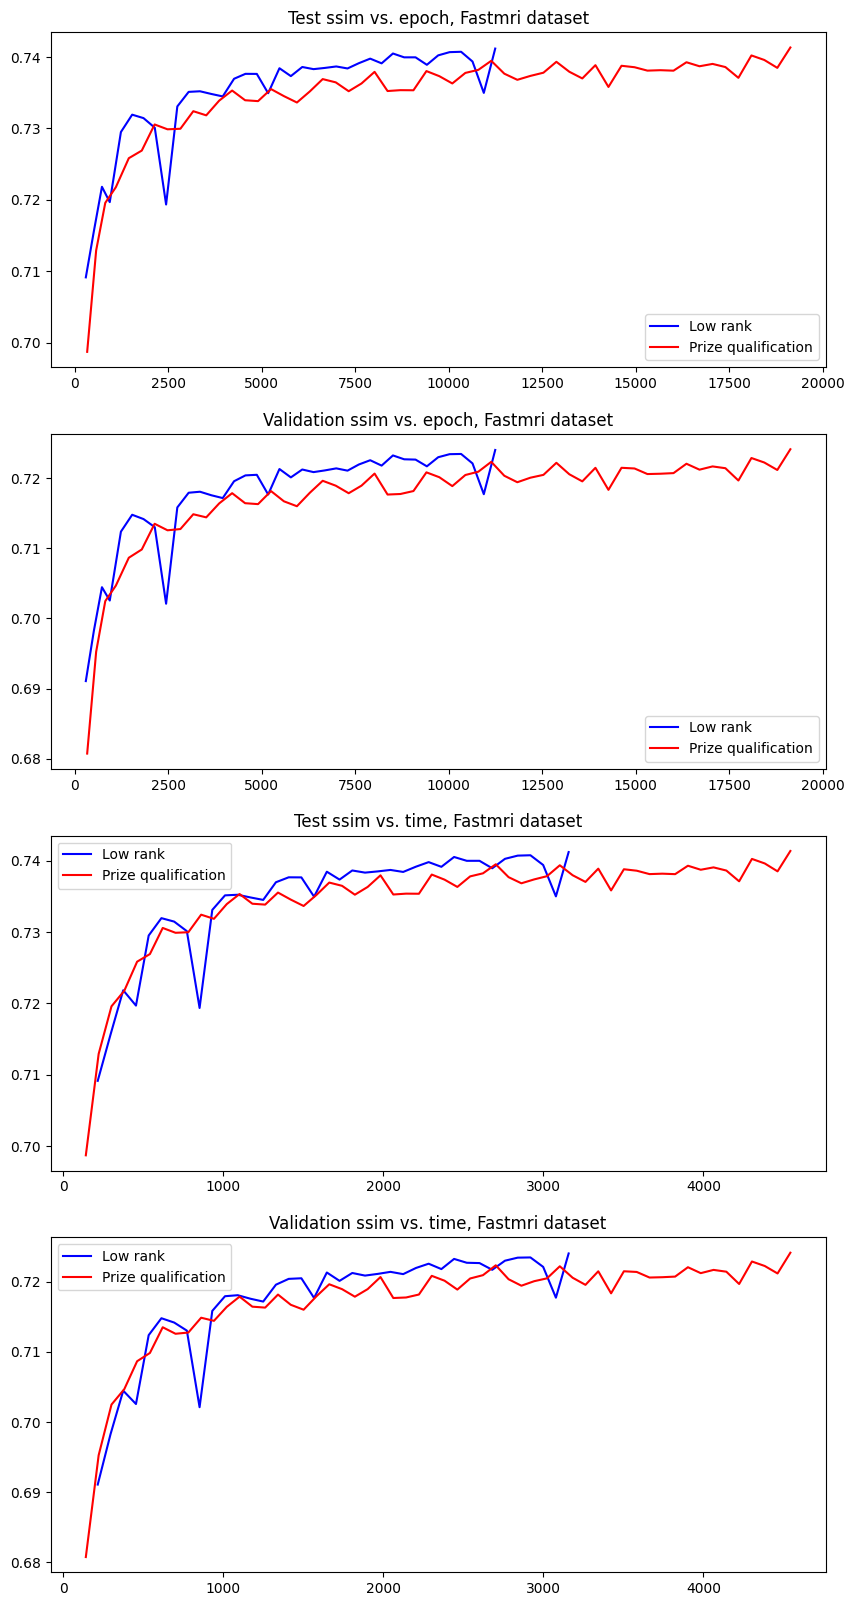

In [17]:
## Compare fastmri prize qualification vs. low rank performance
## Note that parameters and rng seed were chosen to match
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
ax1.set_title("Test ssim vs. epoch, Fastmri dataset")
ax1.plot(low_rank_fastmri['global_step'][1:], low_rank_fastmri['test/ssim'][1:],'b-', label='Low rank')
ax1.plot(prize_qual_fastmri['global_step'][1:], prize_qual_fastmri['test/ssim'][1:], 'r-', label='Prize qualification')
ax1.legend()
ax2.set_title("Validation ssim vs. epoch, Fastmri dataset")
ax2.plot(low_rank_fastmri['global_step'][1:], low_rank_fastmri['validation/ssim'][1:],'b-', label='Low rank')
ax2.plot(prize_qual_fastmri['global_step'][1:], prize_qual_fastmri['validation/ssim'][1:], 'r-', label='Prize qualification')
ax2.legend()
ax3.set_title("Test ssim vs. time, Fastmri dataset")
ax3.plot(low_rank_fastmri['accumulated_submission_time'][1:], low_rank_fastmri['test/ssim'][1:],'b-', label='Low rank')
ax3.plot(prize_qual_fastmri['accumulated_submission_time'][1:], prize_qual_fastmri['test/ssim'][1:], 'r-', label='Prize qualification')
ax3.legend()
ax4.set_title("Validation ssim vs. time, Fastmri dataset")
ax4.plot(low_rank_fastmri['accumulated_submission_time'][1:], low_rank_fastmri['validation/ssim'][1:],'b-', label='Low rank')
ax4.plot(prize_qual_fastmri['accumulated_submission_time'][1:], prize_qual_fastmri['validation/ssim'][1:], 'r-', label='Prize qualification')
ax4.legend()


### About the algorithms
- The prize qualification implementation and log files can be found at [Prize qualification and logs](https://github.com/mlcommons/algorithmic-efficiency/tree/main/prize_qualification_baselines/external_tuning)
- As the proposed algorithm modifies the gradients before the communication step, we can insert it into our choice of optimizers. For the sake of comparison, here we have chosen the above implementation of nadamw including the choice of parameters and rng seed.
- The results here are only preliminary.